# AKAMAI Technologies Inc Report by Sodiq Adebiyi

## Data importation and manipulation

**NOTE: To execute program, set 'mypath' to directory of zip file.**<br>
**Please rename zip file to Archive.zip and put in a new folder to run script**<br>
**Import Libraries and install dependencies**

Please note that this works end to end as in a pipeline and the program will fail to run if the Zip forlder is not named 'Archive'. For easy execution, copy the archive zip file to an empty folder, set mypath to the directory of that folder as prompted in frame 2.

In [1]:
import time
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

from os import listdir
from os.path import isfile, join

try:
    from zipfile import ZipFile
except:
    !pip install zipfile

In [2]:
mypath = input('Enter directory containing Arcive.zip----> ') #format----------> 'C:/Users/olola/Downloads/Akamai Files

Enter directory containing Arcive.zip----> C:/Users/olola/Downloads/Akamai Files


In [3]:
start_time = time.time()

In [4]:
def zipExtractor():                   
    with ZipFile(mypath+'/Archive.zip', 'r') as zipObj:
        zipObj.extractall(mypath+'/Archive')

<em>Import all the JSON files into the 'dictOfFiles' dictionary to begin parsing</em>

In [5]:
def parseDict(mypath):
    files = [f for f in os.listdir(mypath+'/Archive/') if os.path.isfile(os.path.join(mypath+'/Archive/',f))]
    filepaths = [mypath+'/Archive/'+ f for f in files]
    dictOfFiles = {}
    for i in range(len(filepaths)):
        dictOfFiles[i] = pd.read_json(filepaths[i], lines=True)
    return dictOfFiles

<em>Concatenate all the files into a single dataframe</em>

In [6]:
def dfMgmt():
    newDF = pd.concat([dictOfFiles[i] for i in range(len(dictOfFiles))], ignore_index = True)
    newDF.head(10)
    return newDF

<em>Manipulate dataframe to fit requirements</em>

In [7]:
def dataManipulationDriver(newDF):
    expOutput = pd.DataFrame(columns = ['url', 'detectedURL',], index = [f for f in range(len(newDF))])
    temp=[]
    for i in range(len(newDF)):
        temp.append(str(newDF['url'].iloc[i]).split('/')[2])
    for label, content in newDF.iteritems():
        if label in ['url', 'total', 'scan_date']:
            expOutput[label] = content
        else:
            pass
    expOutput.rename(columns = {'total': 'totalScannedEngines'}, inplace = True)
    expOutput['FDQN'] = pd.DataFrame(temp)
    init = []
    init2 = []
    for index, content in newDF.iterrows():
        eng = []
        for x in content[-1].keys():
            if content[-1][x]['detected']==True:
                eng.append(x)
        init.append(eng)
        init2.append(len(eng))
    expOutput['detectedURL'] = init
    expOutput['numberOfDetectionEngines'] = init2
    return expOutput

<em>Extract information about each engine</em>

In [8]:
def extractEngInfo(expOutput):
    temp = []
    for i in range(len(expOutput)):
        for j in range(len(expOutput['detectedURL'].iloc[i])):
            temp.append(expOutput['detectedURL'].iloc[i][j])
    engCount = {}
    for i in set(temp):
        engCount[i] = temp.count(i)
    del(temp)
    engCountDF = pd.DataFrame.from_dict(engCount, orient = 'index')
    engCountDF.reset_index(level=0, inplace=True)
    engCountDF = engCountDF.rename(columns = {'index': 'Engines', 0: 'Detections'})
    engCountDF = engCountDF.sort_values(by = 'Detections', ascending = False)
    return engCountDF

## Data Visualization

<em>Create a Bar Chart for the top 10 engines</em>

In [9]:
def createBarPlot(simDF):
    clrs = ['grey' if (x < max(simDF['Detections'])) else 'red' for x in simDF['Detections'].to_list() ]
    sns.barplot(x='Engines', y = 'Detections', data = simDF, palette = clrs)
    plt.xticks(rotation=90)
    plt.show()

<em>Create heatmap to visualize similarity</em>

In [10]:
def createHeatMap(simDF):#simDF.to_excel('C:/Users/olola/Downloads/Akamai Files/similarity.xlsx')
    for i in simDF['Engines'].tolist():
        simDF[i] = 0
    lx = simDF.columns.tolist()
    lx.remove('Engines')
    lx.remove('Detections')
    #lx is a list of all the engines
    for i in lx:
        for j in range(len(simDF)):
            if simDF['Detections'].iloc[j] < simDF[simDF['Engines']==i]['Detections'].tolist()[0]:
                simDF[i].iloc[j] = (simDF['Detections'].iloc[j] / simDF[simDF['Engines']==i]['Detections'].tolist()[0]) * 100
            elif simDF[simDF['Engines']==i]['Detections'].tolist()[0] < simDF['Detections'].iloc[j]:
                simDF[i].iloc[j] = (simDF[simDF['Engines']==i]['Detections'].tolist()[0] / simDF['Detections'].iloc[j]) * 100
            else:
                simDF[i].iloc[j] = 100

    try:
        simDF.to_csv(path_or_buf = mypath+'/ExtractedFiles/similarity.csv')
    except:
        pass
    temp = simDF.copy(deep = False)
    temp = temp.drop(columns = ['Detections'])
    temp.set_index('Engines', inplace = True)
    temp
    sns.heatmap(data = temp)

<em>Create Cumulative Distribution Frequency curve</em>

In [11]:
def createCDF(engCountDF):
    csum = engCountDF['Detections'].sum()
    for i in range(len(engCountDF)):
        engCountDF['PercentageOfDetection'] = (engCountDF['Detections']/csum) *100
        engCountDF['CumSumPercentages'] = engCountDF['PercentageOfDetection'].cumsum(axis=0)
    engCountDF = engCountDF.sort_values(by = 'CumSumPercentages', ascending = True)
    try:
        engCountDF.to_csv(path_or_buf = mypath+'/ExtractedFiles/cdfData.csv')
    except:
        pass
    #engCountDF
    engCountDF = engCountDF.sort_values(by = 'PercentageOfDetection', ascending = True)
    norm_cdf = scipy.stats.norm.cdf(engCountDF['PercentageOfDetection']) # calculate the cdf - also discrete

    # plot the cdf
    sns.set(rc={'figure.figsize':(13.7,12.27)})
    sns.lineplot(x=engCountDF['Engines'], y=norm_cdf)
    plt.xticks(rotation=90)
    plt.show()

## Other Information Gathering 

<em>Print dataframe showing url and sophos label</em>

In [12]:
def urlClass():
    output2 = newDF.sort_values(by = 'positives', ascending = False,)
    output2 = output2.head(10)
    output2 = output2.reset_index()
    df = pd.DataFrame(np.zeros((len(output2), 2)), columns = ['url', 'category'])

    for index, value in output2.iterrows():
        df['url'].iloc[index] = value[3]
        df['category'].iloc[index]=value[13]['sophos category']
    return df

## Execute Program

In [13]:
zipExtractor()
dictOfFiles = parseDict(mypath)
newDF = dfMgmt()
try:
    newDF.to_csv(path_or_buf = mypath+'/ExtractedFiles/Combined_Dataset.csv')
except:
    pass

In [14]:
expOutput = dataManipulationDriver(newDF)

In [15]:
try:
    expOutput.to_csv(path_or_buf = mypath+'/ExtractedFiles/transformedDS.csv')
except:
    pass
expOutput.sort_values(by='totalScannedEngines', ascending = False).head(10)

,url,detectedURL,scan_date,totalScannedEngines,FDQN,numberOfDetectionEngines
4212,http://paypial-us.com/,"[Comodo Valkyrie Verdict, Scantitan, AlienVaul...",2021-05-07 08:53:45,90,paypial-us.com,25
2276,http://cancelnewlogin.com/,"[Comodo Valkyrie Verdict, AlienVault, Sophos, ...",2021-05-07 08:53:38,89,cancelnewlogin.com,12
9250,https://www.paxful.mariagiovannalupu.com/verif...,"[Sophos, Phishtank, Fortinet, Google Safebrows...",2021-05-07 08:53:44,89,www.paxful.mariagiovannalupu.com,18
4362,http://protect-mylogindetails.com/,"[Comodo Valkyrie Verdict, AlienVault, Sophos, ...",2021-05-07 08:53:46,89,protect-mylogindetails.com,21
4065,https://docsharex-authorize.firebaseapp.com/,"[Comodo Valkyrie Verdict, AlienVault, Sophos, ...",2021-05-07 08:53:46,89,docsharex-authorize.firebaseapp.com,24
3564,https://docsharex-authorize.firebaseapp.com/xx,"[Comodo Valkyrie Verdict, AlienVault, Sophos, ...",2021-05-07 08:53:44,89,docsharex-authorize.firebaseapp.com,24
484,https://telete.in/jagressor_kz,"[Comodo Valkyrie Verdict, Sophos, Fortinet, al...",2021-05-07 08:59:00,89,telete.in,12
4752,http://cdn.discordapp.com/attachments/75084237...,"[MalwarePatrol, MalSilo]",2021-05-07 08:53:54,88,cdn.discordapp.com,2
21224,http://v29340.1blu.de/,[AutoShun],2021-05-07 09:04:25,88,v29340.1blu.de,1
31071,http://lookitme.com/,[],2021-05-07 09:07:27,88,lookitme.com,0


In [16]:
engCountDF = extractEngInfo(expOutput)
simDF = engCountDF.head(10)
simDF

,Engines,Detections
6,Fortinet,2786
31,Webroot,2770
36,MalwarePatrol,2592
12,CyRadar,2365
24,alphaMountain.ai,1961
51,Comodo Valkyrie Verdict,1563
9,CRDF,1453
53,Sophos,1216
22,G-Data,1195
8,ESET,905


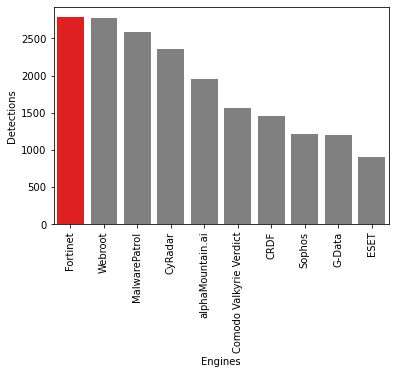

In [17]:
createBarPlot(simDF)

<ipython-input-10-c3f8d2dfff40>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simDF[i] = 0
C:\Users\olola\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-10-c3f8d2dfff40>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simDF[i].iloc[j] = 100
<ipython-input-10-c3f8

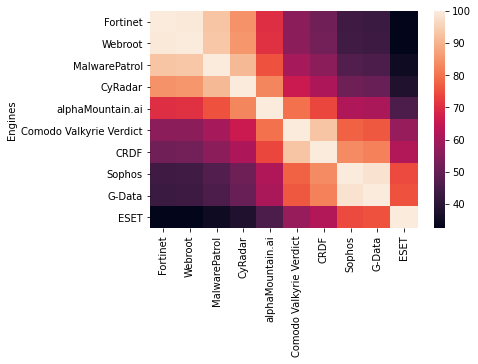

In [18]:
createHeatMap(simDF)

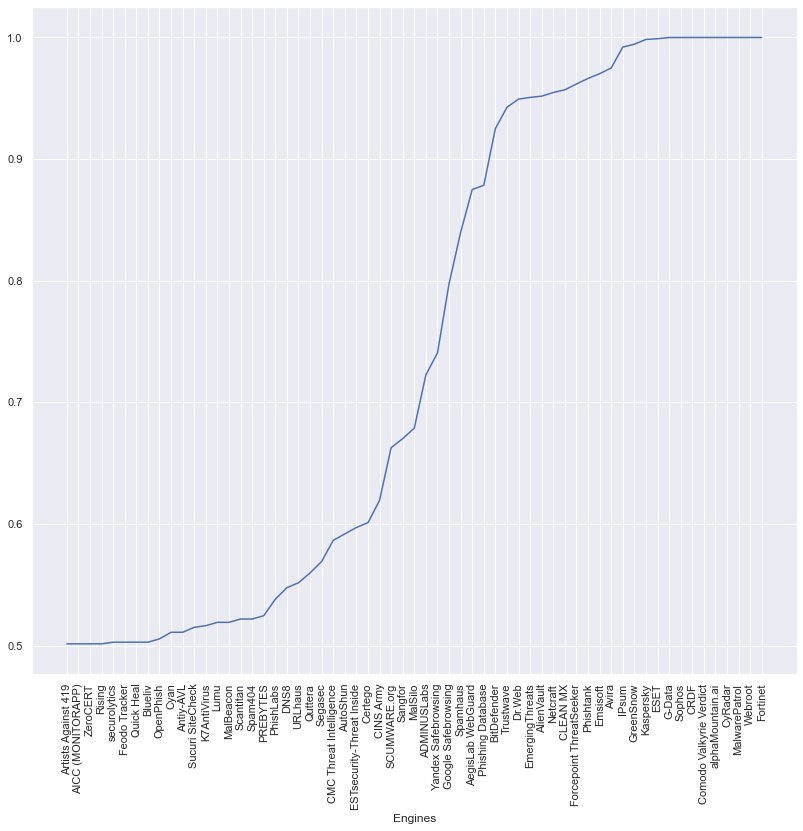

In [19]:
createCDF(engCountDF)

In [20]:
df = urlClass()
df

C:\Users\olola\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,url,category
0,http://paypial-us.com/,"illegal phishing, phishing and fraud"
1,https://docsharex-authorize.firebaseapp.com/,"malware repository, spyware and malware"
2,https://docsharex-authorize.firebaseapp.com/xx,"malware repository, spyware and malware"
3,https://confirm-mypayees-support.com/Login.php,"malware repository, spyware and malware"
4,https://joingrupwhatsapp6.duckdns.org/,"illegal phishing, phishing and fraud"
5,http://107.172.43.154/public/banks/tangerine/,"illegal phishing, phishing and fraud"
6,https://certicobanque.cf/MGen/F6cc906b5ba22e73...,"illegal phishing, phishing and fraud"
7,http://grubtantenadiah.crotteros.cf/,"illegal phishing, phishing and fraud"
8,http://onlinehalifax-account.com/Halifax,"malware repository, spyware and malware"
9,https://tokendigital.1bn-zonaseguraperu.com/BN...,"malware repository, spyware and malware"


### Execution Time

In [21]:
print("Execution time-----> %s seconds ---" % (time.time() - start_time))

Execution time-----> 38.83536982536316 seconds ---
